# **Thư viện**

In [24]:
import pandas as pd
import numpy as np
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# **Dữ liệu**

In [25]:
data = pd.read_csv("../data/processed/EUR_VND_Exchange_Rate.csv", parse_dates=["Date"])
data.set_index("Date", inplace=True) 
data = data[["Sell"]].copy()
data.head()

,Sell
Date,
2020-04-01,26506.55
2020-04-02,26506.55
2020-04-03,25936.23
2020-04-04,25936.23
2020-04-05,25936.23


# **Chuẩn hóa dữ liệu**

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
df_scaled = pd.DataFrame(data_scaled, index=data.index, columns=["Sell"])

# **Chia Train/Test**

In [27]:
values = df_scaled["Sell"].values.astype(np.float32)
timestamps = df_scaled.index

train_size = int(len(values) * 0.8)
train_values, test_values = values[:train_size], values[train_size:]
train_timestamps, test_timestamps = timestamps[:train_size], timestamps[train_size:]

# --- TẠO SEQUENCES ---
seq_length = 30
def create_sequences(values, timestamps):
    X, y, y_timestamps = [], [], []
    for i in range(len(values) - seq_length):
        X.append(values[i : i + seq_length])
        y.append(values[i + seq_length])
        y_timestamps.append(timestamps[i + seq_length])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(y_timestamps)

X_train, y_train, time_train = create_sequences(train_values, train_timestamps)
X_test, y_test, time_test = create_sequences(test_values, test_timestamps)


In [28]:
# Reshape input cho LSTM: (samples, time steps, features)
X_train = X_train.reshape(-1, seq_length, 1)
X_test = X_test.reshape(-1, seq_length, 1)

# **Mô hình LSTM**

In [29]:
# --- XÂY DỰNG MÔ HÌNH ---
def build_lstm_model(hp, seq_length):
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))
    model.add(LSTM(
        units=hp.Int("lstm_units_2", 32, 128, 16),
        return_sequences=False,
        activation="tanh",
        kernel_regularizer=l2(hp.Choice("l2_reg", [0.001, 0.01, 0.1]))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, 0.1)))
    model.add(Dense(hp.Int("dense_units", 16, 64, 16), activation="relu"))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

In [30]:
# --- HUẤN LUYỆN MÔ HÌNH ---
def train_lstm(X_train, y_train, X_test, y_test, seq_length, model_path, project_name):
    tuner = kt.RandomSearch(
        lambda hp: build_lstm_model(hp, seq_length),
        objective="val_loss",
        max_trials=10,
        executions_per_trial=2,
        directory=r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\models",
        project_name=project_name
    )

    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_path, save_best_only=True)

    tuner.search(X_train, y_train,
                 epochs=100,
                 batch_size=32,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, model_checkpoint])

    return tuner.get_best_hyperparameters(num_trials=1)[0]

In [31]:
import shutil
import os

tuner_dir = r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\models\LSTM"

if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

In [32]:
best_hp = train_lstm(
    X_train, y_train,
    X_test, y_test,
    seq_length=30,
    model_path=r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\models\LSTM\best_lstm.h5",
    project_name="LSTM"
)

Trial 10 Complete [00h 01m 05s]
val_loss: 0.012865345925092697

Best val_loss So Far: 0.0006091580144129694
Total elapsed time: 00h 11m 46s


In [33]:
best_hp.values

{'lstm_units_2': 32,
 'l2_reg': 0.01,
 'dropout_2': 0.1,
 'dense_units': 64,
 'learning_rate': 0.001}

# **Đánh giá mô hình**

In [34]:
best_model = load_model(r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\models\LSTM\best_lstm.h5", compile=False)
y_pred = best_model.predict(X_test).flatten()

# Inverse transform về giá gốc
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()

# Metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 147.5088653564453
MSE: 32648.646484375
RMSE: 180.68936157226562
MAPE: 0.005321864303480679


# **Thực tế và dự đoán**

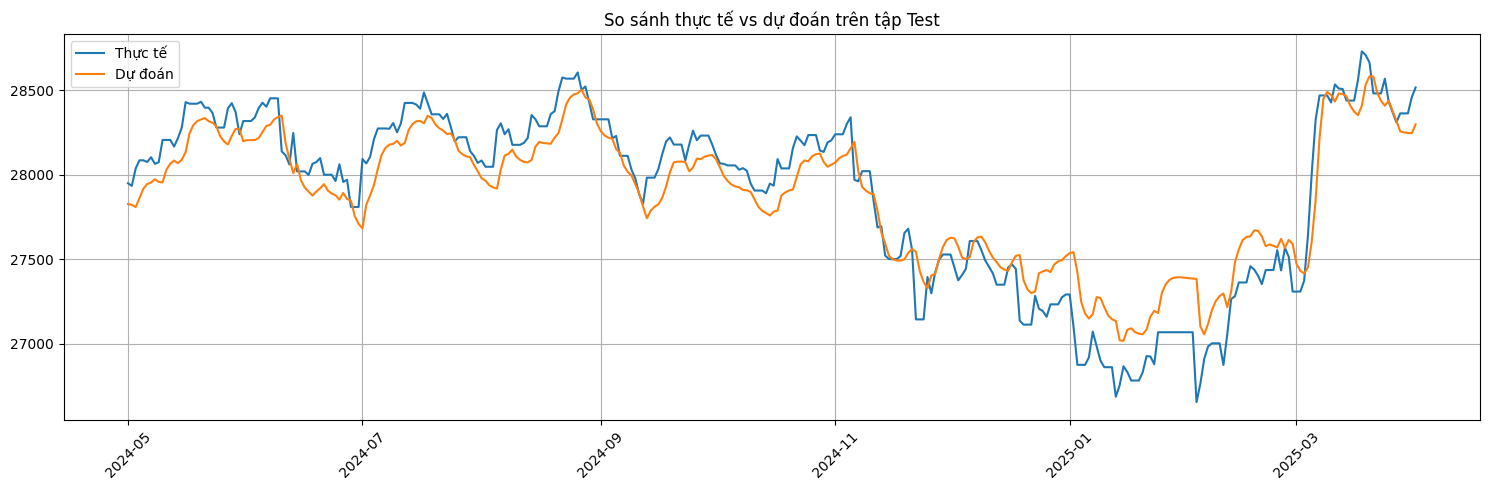

In [35]:
plt.figure(figsize=(15,5))
plt.plot(time_test, y_test_actual, label="Thực tế")
plt.plot(time_test, y_pred_actual, label="Dự đoán")
plt.legend()
plt.title("So sánh thực tế vs dự đoán trên tập Test")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Dự đoán 30 ngày tiếp theo**

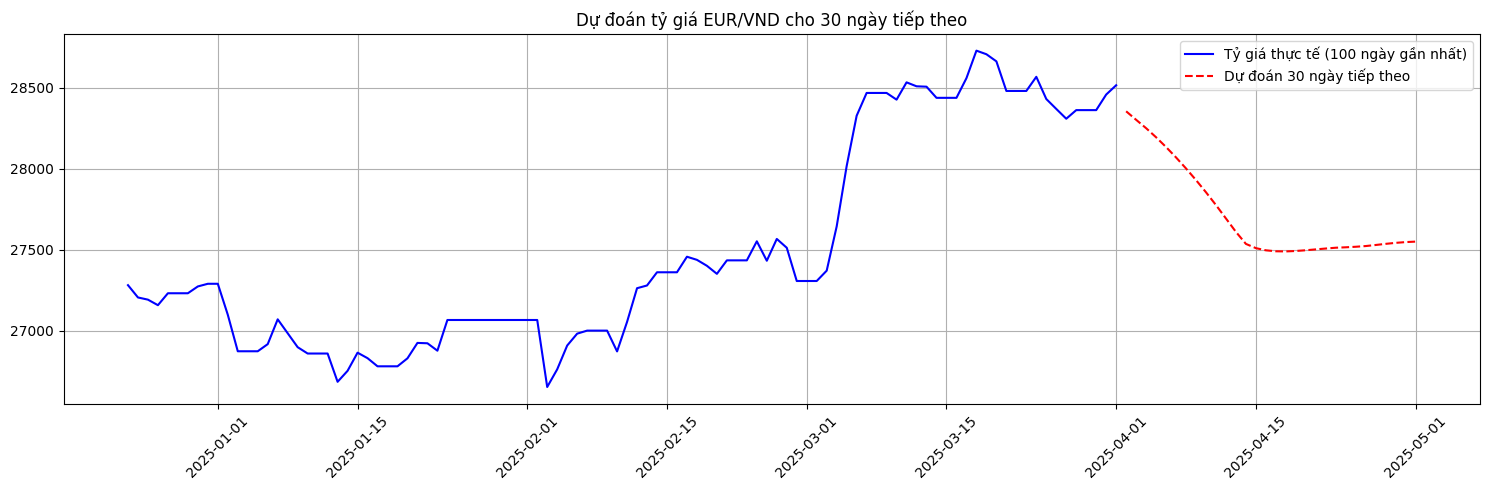

In [ ]:
last_sequence = values[-seq_length:].reshape(1, seq_length, 1).astype(np.float32)

future_preds = []
input_seq = last_sequence.copy()

for _ in range(30):
    next_pred = best_model.predict(input_seq, verbose=0)[0][0]
    future_preds.append(next_pred)
    input_seq = np.append(input_seq[:, 1:, :], [[[next_pred]]], axis=1)

# Chuyển dự đoán về giá gốc
future_preds_actual = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

last_date = df_scaled.index[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 31)]

# Biểu đồ dự đoán 30 ngày
plt.figure(figsize=(15,5))
plt.plot(df_scaled.index[-100:], scaler.inverse_transform(values[-100:].reshape(-1,1)), label="Tỷ giá thực tế (100 ngày gần nhất)", color="blue")
plt.plot(future_dates, future_preds_actual, label="Dự đoán 30 ngày tiếp theo", color="red", linestyle="--")
plt.legend()
plt.title("Dự đoán tỷ giá EUR/VND cho 30 ngày tiếp theo")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()